In [1]:
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import logging
import numpy as np
import rasterio
#import fiona
import os, sys
import pandas as pd
from datetime import datetime, date, timedelta
import watershed_workflow
import time
import cftime

In [2]:
df = pd.read_csv('WS_2016_2019.csv')

In [3]:
df.head(500000)

,DateTime,Temp_F,Incoming_Rad_Wm2,Wind_Speed_ms,Rain (m s^-1),time (s),RH (-),Unnamed: 7,Unnamed: 8,Unnamed: 9
0,8/23/16 11:20,89.685,759.4,0.929817,0.0,20344800,0.664,NaN,NaN,NaN
1,8/23/16 11:25,90.286,790.6,1.108628,0.0,20345100,0.670,NaN,NaN,NaN
2,8/23/16 11:30,90.891,798.1,0.558784,0.0,20345400,0.651,NaN,NaN,NaN
3,8/23/16 11:35,90.612,756.9,1.300849,0.0,20345700,0.683,NaN,NaN,NaN
4,8/23/16 11:40,90.194,700.6,1.479660,0.0,20346000,0.665,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
276741,4/11/19 9:05,75.117,687.0,7.000000,0.0,103367100,0.703,NaN,NaN,NaN
276742,4/11/19 9:10,75.160,687.0,7.000000,0.0,103367400,0.688,NaN,NaN,NaN
276743,4/11/19 9:15,75.074,687.0,8.000000,0.0,103367700,0.666,NaN,NaN,NaN
276744,4/11/19 9:20,75.767,687.0,8.000000,0.0,103368000,0.644,NaN,NaN,NaN


In [5]:

time = df['time (s)']

start = datetime.strptime('2016-01-01 00:00:00','%Y-%m-%d %H:%M:%S')
ts = datetime.timestamp(start)
reslist = []
for sec in time:
    res_date = ts + sec
    res = datetime.fromtimestamp(res_date)
    reslist.append(res)


df.index = pd.to_datetime(reslist)
df = df.drop(columns=['DateTime','Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'])

df = df.resample('h').mean()


df.head(500000)

,Temp_F,Incoming_Rad_Wm2,Wind_Speed_ms,Rain (m s^-1),time (s),RH (-)
2016-08-23 11:00:00,90.595000,752.812500,1.065601,0.0,20345850.0,0.662500
2016-08-23 12:00:00,91.692083,778.441667,1.111608,0.0,20348850.0,0.635917
2016-08-23 13:00:00,90.476000,427.083333,0.712263,0.0,20352450.0,0.679333
2016-08-23 14:00:00,90.922500,553.441667,0.943228,0.0,20356050.0,0.682917
2016-08-23 15:00:00,92.599500,660.408333,0.927954,0.0,20359650.0,0.651917
...,...,...,...,...,...,...
2019-04-11 05:00:00,58.561500,4.000000,1.916667,0.0,103354050.0,0.927250
2019-04-11 06:00:00,60.229750,116.500000,4.000000,0.0,103357650.0,0.922417
2019-04-11 07:00:00,66.361583,328.500000,6.000000,0.0,103361250.0,0.846667
2019-04-11 08:00:00,72.180083,544.000000,6.166667,0.0,103364850.0,0.754417


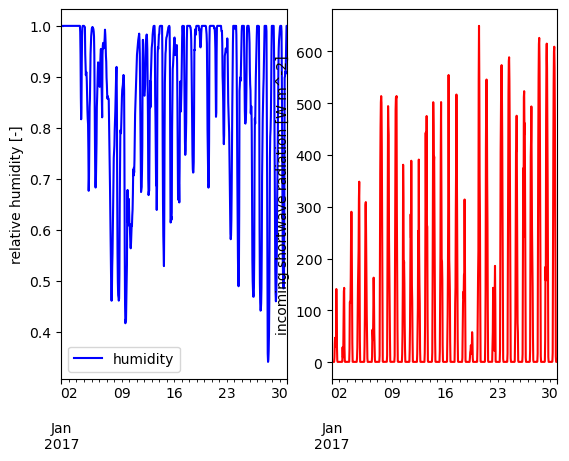

In [6]:
# plot a few of the met data -- does it look reasonable?
def plotMetData(df):
    df_yr = df.loc['2017-1-01':'2017-01-30']
    fig = plt.figure()
    ax = fig.add_subplot(121)    
    df_yr['RH (-)'].plot(color='b', label='humidity')
    ax.set_ylabel('relative humidity [-]')
    ax.set_title('')
    ax.legend()
    
    ax = fig.add_subplot(122)
    df_yr['Incoming_Rad_Wm2'].plot(color='r', label='qSW_in')
    ax.set_ylabel('incoming shortwave radiation [W m^-2]')
    ax.set_title('')
    
    plt.show()

plotMetData(df)

In [7]:
# Force the dataframe to a specific frequency (e.g., Hourly 'H')
# Gaps will appear as NaN

# Identify the gaps
gaps = df[df['Wind_Speed_ms'].isna()]
print(gaps)

Empty DataFrame
Columns: [Temp_F, Incoming_Rad_Wm2, Wind_Speed_ms, Rain (m s^-1), time (s), RH (-)]
Index: []


In [8]:
precip_mean = precip.mean()
print(precip_mean)

NameError: name 'precip' is not defined

In [9]:
time = df['time (s)']
precip = df['Rain (m s^-1)']

f = h5py.File("shambley_met_hourly.h5", "w")
f.create_dataset('precipitation rain [m s^-1]', data=precip)
f.create_dataset('time [s]', data=time)


<HDF5 dataset "time [s]": shape (23063,), type "<f8">

In [10]:
# 'air temperature [K]' 
tempF = df['Temp_F']
tempK = ((tempF - 32)*(5/9)) + 273.15 
f.create_dataset('air temperature [K]', data=tempK)
tempC = ((tempF - 32)*(5/9)) 


# 'incoming shortwave radiation [W m^-2]'
solar = df['Incoming_Rad_Wm2']
f.create_dataset('incoming shortwave radiation [W m^-2]', data=solar)

# 'precipitation snow [m SWE s^-1]'
listlen = len(tempK)
snowlist = [0]*listlen
snowdf = pd.Series(snowlist)
f.create_dataset('precipitation snow [m SWE s^-1]', data=snowdf)

# 'relative humidity [-]'

humid = df['RH (-)']
f.create_dataset('relative humidity [-]', data=humid)

# 'wind speed, '
wind = df['Wind_Speed_ms']
f.create_dataset('wind speed [m s^-1]', data=wind)

# Get Vapor pressure in Pa
vp_mb = 6.1078**((17.269*tempC) / (237.3+tempC))
vp = vp_mb*100
f.create_dataset('vapor pressure air [Pa]', data=vp)


f.close()

In [11]:
f.close()


Keys: ['air temperature [K]', 'incoming shortwave radiation [W m^-2]', 'precipitation rain [m s^-1]', 'precipitation snow [m SWE s^-1]', 'relative humidity [-]', 'time [s]', 'vapor pressure air [Pa]', 'wind speed [m s^-1]']


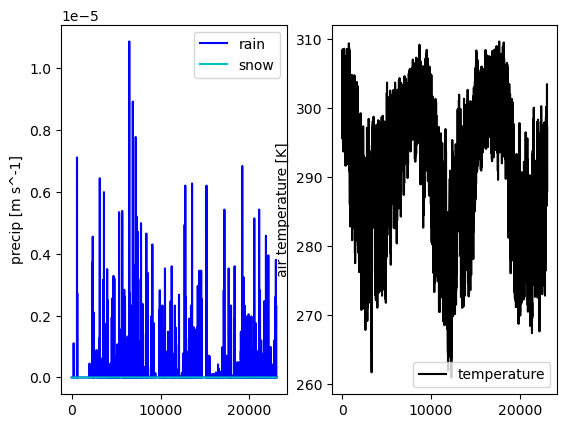

In [13]:
# 1. Open the file in read-only mode
with h5py.File('shambley_met_hourly.h5', 'r') as f:
    
    # 2. List keys to identify datasets
    print("Keys:", list(f.keys()))
    
    fig = plt.figure()
    
    ax = fig.add_subplot(121)    
    precip = f['precipitation rain [m s^-1]'][:]
    snow = f['precipitation snow [m SWE s^-1]'][:]
    ax.plot(precip, color='b', label='rain')
    ax.plot(snow, color='c', label='snow')
    ax.set_ylabel('precip [m s^-1]')
    ax.set_title('')
    ax.legend()
    
    #ax = fig.add_subplot(122)
    #rad = f['incoming shortwave radiation [W m^-2]'][:]
    #ax.plot(rad, color='r', label='radiation')
    #ax.set_ylabel('incoming shortwave radiation [W m^-2]')
    #ax.set_title('')
    #ax.legend()
     
    #ax = fig.add_subplot(121)
    #wind = f['wind speed [m s^-1]'][:]
    #ax.plot(wind, color='gray', label='humidity')
    #ax.set_ylabel('wind speed [m s^-1]')
    #ax.set_title('')
    #ax.legend()
        
    ax = fig.add_subplot(122)
    temp = f['air temperature [K]'][:]
    ax.plot(temp, color='k', label='temperature')
    ax.set_ylabel('air temperature [K]')
    ax.set_title('')
    ax.legend()

    
    #ax = fig.add_subplot(122)
    #hum = f['relative humidity [-]'][:]
    #ax.plot(hum, color='g', label='humidity')
    #ax.set_ylabel('relative humidity [-]')
    #ax.set_title('')
    #ax.legend()

    plt.show()

In [ ]:
# cannot compute a typical year for leap year -- need to align days-of-the-year
# remove leap day (Dec 31 of leap years)
df = df.reset_index(names=['time'])

#print(df.head())
#df['time'] = df['index']

met_data_noleap = watershed_workflow.data.filterLeapDay(df)
met_data_noleap

# then compute a "typical" year
met_data_typical = watershed_workflow.data.computeAverageYear(met_data_noleap, 'time', 2010, 6)

# and lastly convert to ATS


In [ ]:
seclist=[]
for t in met_data_typical['time']:
    seconds = cftime.date2num(t, units="seconds since 2010-01-01 00:00:00", calendar="noleap")
    seclist.append(seconds)

met_data_typical['time (s)'] = seclist

In [ ]:
met_data_typical.head(50000)

In [ ]:
f = h5py.File("shambley_cyclic.h5", "w")

precip = met_data_typical['Rain (m s^-1)']
f.create_dataset('precipitation rain [m s^-1]', data=precip)

time = met_data_typical['time (s)']
f.create_dataset('time [s]', data=time)

# 'air temperature [K]' 
tempF = met_data_typical['Temp_F']
tempK = ((tempF - 32)*(5/9)) + 273.15 
f.create_dataset('air temperature [K]', data=tempK)
tempC = ((tempF - 32)*(5/9)) 


# 'incoming shortwave radiation [W m^-2]'
solar = met_data_typical['Incoming_Rad_Wm2']
f.create_dataset('incoming shortwave radiation [W m^-2]', data=solar)

# 'precipitation snow [m SWE s^-1]'
listlen = len(tempK)
snowlist = [0]*listlen
snowdf = pd.Series(snowlist)
f.create_dataset('precipitation snow [m SWE s^-1]', data=snowdf)

# 'relative humidity [-]'
humid = met_data_typical['RH (-)']
f.create_dataset('relative humidity [-]', data=humid)

# 'wind speed, '
wind = met_data_typical['Wind_Speed_ms']
f.create_dataset('wind speed [m s^-1]', data=wind)

# Get Vapor pressure in Pa
vp_mb = 6.1078**((17.269*tempC) / (237.3+tempC))
vp = vp_mb*100
f.create_dataset('vapor pressure air [Pa]', data=vp)

f.close()

In [ ]:
# 1. Open the file in read-only mode
with h5py.File('shambley_cyclic.h5', 'r') as f:
    
    # 2. List keys to identify datasets
    print("Keys:", list(f.keys()))
    
    fig = plt.figure()
    
    ax = fig.add_subplot(121)    
    precip = f['precipitation rain [m s^-1]'][:]*60*60
    snow = f['precipitation snow [m SWE s^-1]'][:]
    ax.plot(precip, color='b', label='rain')
    ax.plot(snow, color='c', label='snow')
    ax.set_ylabel('precip [m s^-1]')
    ax.set_title('')
    ax.legend()
    
    #ax = fig.add_subplot(122)
    #rad = f['incoming shortwave radiation [W m^-2]'][:]
    #ax.plot(rad, color='r', label='radiation')
    #ax.set_ylabel('incoming shortwave radiation [W m^-2]')
    #ax.set_title('')
    #ax.legend()
     
    #ax = fig.add_subplot(121)
    #wind = f['wind speed [m s^-1]'][:]
    #ax.plot(wind, color='gray', label='humidity')
    #ax.set_ylabel('wind speed [m s^-1]')
    #ax.set_title('')
    #ax.legend()
        
    #ax = fig.add_subplot(122)
    #temp = f['air temperature [K]'][:]
    #ax.plot(temp, color='k', label='temperature')
    #ax.set_ylabel('air temperature [K]')
    #ax.set_title('')
    #ax.legend()

    
    ax = fig.add_subplot(122)
    hum = f['relative humidity [-]'][:]
    ax.plot(hum, color='g', label='humidity')
    ax.set_ylabel('relative humidity [-]')
    ax.set_title('')
    ax.legend()

    plt.show()